## Imports

In [1]:
## Data Read
import dask.bag as db
import json

## Dataframes and Analytics
import pandas as pd
import numpy as np

## Plotting
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt

## Stop Words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

## Data Preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

## Cross Validation
from sklearn.calibration import CalibratedClassifierCV

## Models/Algorithms
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Metrics
from sklearn.metrics import accuracy_score, roc_curve, auc, hamming_loss

## Miscellanous
from sklearn.pipeline import Pipeline

### Reading dataset using Dask

In [2]:
SEED = 4 # bounces

docs = db.read_text('arxiv-metadata-oai-snapshot.json').map(json.loads)

# get only necessary fields
trim = lambda x: {'id': x['id'],
                  'title': x['title'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract']}

### Original count of dataset

In [59]:
docs.count().compute()

1789907

### To perform multi-label task classification, we select only "id", "title", "category" and "abstract" columns and filter papers published on or after 2015-01-01

In [60]:
get_latest_version = lambda x: x['versions'][-1]['created']
# filter for papers published on or after 2019-01-01
columns = ['id','category','abstract']
docs_df = (docs
             .filter(lambda x: int(get_latest_version(x).split(' ')[3]) > 2015)
             .map(trim)
             .compute())

# convert to pandas
docs_df = pd.DataFrame(docs_df)

# add general category. we are going to use as our target variable
docs_df['general_category'] = docs_df.category.apply(lambda x:[a.split('.')[0] for a in x])

docs_df

,id,title,category,abstract,general_category
0,0704.0189,Monoid generalizations of the Richard Thompson...,[math.GR],"The groups G_{k,1} of Richard Thompson and G...",[math]
1,0704.0558,M-regularity of the Fano surface,[math.AG],"Let $(A,\Theta)$ be a principally polarised ...",[math]
2,0704.0775,K_0-theory of n-potents in rings and algebras,"[math.KT, math.RA]",Let $n \geq 2$ be an integer. An \emph{$n$-p...,"[math, math]"
3,0704.1291,Projective Hilbert space structures at excepti...,"[math-ph, cond-mat.other, math.MP, quant-ph]",A non-Hermitian complex symmetric 2x2 matrix...,"[math-ph, cond-mat, math, quant-ph]"
4,0704.1445,Deformed Wigner crystal in a one-dimensional q...,"[cond-mat.str-el, cond-mat.mes-hall]",The spatial Fourier spectrum of the electron...,"[cond-mat, cond-mat]"
...,...,...,...,...,...
719804,quant-ph/0702160,Discrete-query quantum algorithm for NAND trees,[quant-ph],"Recently, Farhi, Goldstone, and Gutmann gave...",[quant-ph]
719805,quant-ph/9606017,Quantum Mechanics in Terms of Realism,[quant-ph],.We expound an alternative to the Copenhagen...,[quant-ph]
719806,quant-ph/9806088,Quantum Games and Quantum Strategies,[quant-ph],We investigate the quantization of non-zero ...,[quant-ph]
719807,quant-ph/9904078,Unconditionally Secure Quantum Coin Tossing,[quant-ph],In coin tossing two remote participants want...,[quant-ph]


### Converting General category to label columns using Multilabel Binarizer

In [61]:
# convert general category into label columns
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(docs_df.general_category)
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

### As title could also help in predicting label, we concatenate abstract and title

In [62]:
df = pd.concat([docs_df[['abstract','title']], pd.DataFrame(labels)], axis=1)
df.columns = ['abstract','title'] + list(mlb.classes_)
df.head(4)

,abstract,title,alg-geom,astro-ph,cond-mat,cs,dg-ga,econ,eess,gr-qc,...,nlin,nucl-ex,nucl-th,physics,q-alg,q-bio,q-fin,quant-ph,solv-int,stat
0,"The groups G_{k,1} of Richard Thompson and G...",Monoid generalizations of the Richard Thompson...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Let $(A,\Theta)$ be a principally polarised ...",M-regularity of the Fano surface,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Let $n \geq 2$ be an integer. An \emph{$n$-p...,K_0-theory of n-potents in rings and algebras,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A non-Hermitian complex symmetric 2x2 matrix...,Projective Hilbert space structures at excepti...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Shuffling the dataset

In [63]:
# shuffle or sample and 
sample_df = df.sample(frac = 1, random_state = SEED)
sample_df

,abstract,title,alg-geom,astro-ph,cond-mat,cs,dg-ga,econ,eess,gr-qc,...,nlin,nucl-ex,nucl-th,physics,q-alg,q-bio,q-fin,quant-ph,solv-int,stat
72441,"In this paper, we consider a nonlinear integ...",A spectral projection method for transmission ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58580,This paper presents a new variation of Tverb...,Quantitative Tverberg theorems over lattices a...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
528229,"In the event of a disaster, saving human liv...",Cognitive Agent Based Simulation Model For Imp...,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198461,Minimizing the empirical risk is a popular t...,Efficient learning with robust gradient descent,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
156449,"In this paper, we initiate a study of a new ...",Two-Party Function Computation on the Reconcil...,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639432,We investigate some aspects of the Maxwell-C...,New point-like sources and a conducting surfac...,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
653672,Real-time vehicle dispatching operations in ...,A Real-Time Dispatching Strategy for Shared Au...,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
120705,Muon component of extensive air showers (EAS...,Cosmic ray composition measurements and cosmic...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
377541,We present the first catalogue of galaxy clu...,AMICO galaxy clusters in KiDS-DR3: sample prop...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Keeping only columns/categories that have at least 1 positive example

In [64]:
keep = sample_df.iloc[:,2:].apply(sum) > 1
sample_df = pd.concat([sample_df.iloc[:,:2],sample_df.iloc[:,2:].iloc[:,keep.values]], axis = 1)

categories = sample_df.columns[2:]
# removed categories
print('Removed following categories from training : {}'.format(str(keep[~keep].index.to_list())))

Removed following categories from training : ['dg-ga', 'solv-int']


### Plotting percentage of each category in the dataset

In [171]:
# plot paper distribution by category
source = pd.DataFrame(sample_df.iloc[:,2:].apply(sum)).reset_index().rename(columns = {0:'count'})
ptotalText = alt.Text('PercentOfTotal:Q', format = '.2%')

chart = alt.Chart(source).transform_joinaggregate(
    TotalPapers='sum(count)',
).transform_calculate(
    PercentOfTotal="datum.count / datum.TotalPapers"
).mark_bar().encode(
    x = 'index',
    y = 'count',
    tooltip = ['index','count', ptotalText]
).properties(
    title='arXiv Papers by Category, after 2015-01-01',
    width = 800
)

# add percentage labels
chart = chart + chart.mark_text(
    align='center',
    baseline='middle',
    dx= 3,  # Nudges text to right so it doesn't appear on top of the bar,
    dy = -5
).encode(
    text = ptotalText
) 

chart

alt.LayerChart(...)

### Plotting PCA Chart using abstracts belonging to only one category

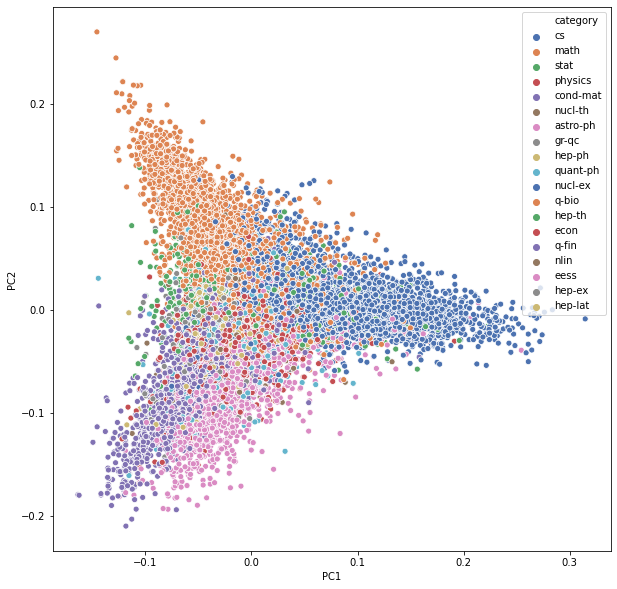

In [67]:
sample_pca = sample_df.loc[sample_df.iloc[:,2:].apply(sum, axis=1) == 1,:].sample(n = 15_000, random_state = 4)

# Generating features using TF-IDF Vectorizer
X = TfidfVectorizer(stop_words=stop_words).fit_transform(sample_pca.abstract).todense()

pca = PCA(n_components=2).fit(X)
data2D = pd.DataFrame(pca.transform(X), columns = ['PC1','PC2'])

# get categories for abstracts
color = sample_pca.iloc[:,2:].apply(lambda x: x.index[x>0][0], axis = 1)
data2D['category'] = color.to_list()

plt.figure(figsize=(10, 10))

sns.scatterplot(data = data2D,
                x = 'PC1', 
                y = 'PC2',
                hue=data2D['category'],
                palette = "deep",
                legend = "brief")

### Splitting the data in train and test sets

In [66]:
# # split into train and test
train, test = train_test_split(sample_df, random_state=SEED, test_size=0.15, shuffle=True)

X_train = train.abstract
X_test = test.abstract

print(X_train.shape)
print(X_test.shape)

(611837,)
(107972,)


## As we are performing with mutli-label classification, we use One-vs-Rest classifier and train different classification models for each category

### As we are using a Pipeline, we define a feature importance function to calculate top 10 features from each model

In [70]:
def feature_importance(pipeline):
    '''
    Extract feature importances from pipeline. 
    Since I am using CalibratedClassifierCV I will average the coefficients over calibrated classifiers.
    '''
    # average coefficients over all calibrated classifiers
    coef_avg = 0
    classifiers = pipeline[1].estimators_[0].calibrated_classifiers_
    for i in classifiers:
        coef_avg = coef_avg + i.base_estimator.coef_
    coef_avg  = (coef_avg/len(classifiers)).tolist()[0]
    # get feature names from tf-idf vectorizer
    features = pipeline[0].get_feature_names()
    # get 10 most important features
    top_f = pd.DataFrame(list(zip(features,coef_avg)), columns = ['token','coef']) \
        .nlargest(10,'coef').to_dict(orient = 'records')
    return top_f

## Model 1 : Linear SVC Model

### Training LinearSVC model for each category

In [71]:
%%time
# define the pipeline
linearSVC_classifier = CalibratedClassifierCV(LinearSVC()) 

# for each category train the model and get accuracy, auc
linearSVC_models = {}
linearSVC_features = {}
linearSVC_preds = {}
for category in categories:
    # give pipelines unique names. important!  
    SVC_pipeline = Pipeline([
                (f'tfidf_{category}', TfidfVectorizer(stop_words=stop_words)),
                (f'clf_{category}', OneVsRestClassifier(linearSVC_classifier, n_jobs=1)),
            ])
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    linearSVC_models[category] = SVC_pipeline
    # compute the testing accuracy
    linearSVC_prediction = SVC_pipeline.predict(X_test)
    linearSVC_preds[category] = linearSVC_prediction
    linearSVC_accuracy = accuracy_score(test[category], linearSVC_prediction)
    # compute auc
    linearSVC_probas_ = SVC_pipeline.predict_proba(X_test)
    linearSVC_fpr, linearSVC_tpr, linearSVC_thresholds = roc_curve(test[category], linearSVC_probas_[:, 1])
    linearSVC_roc_auc = auc(linearSVC_fpr, linearSVC_tpr)
    print("Accuracy : {} . Area under the ROC curve : {}".format(round(linearSVC_accuracy,4), round(linearSVC_roc_auc,4)))
    print()
    # get most predictive features
    linearSVC_features[category] = feature_importance(SVC_pipeline)

... Processing alg-geom


/Users/admin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/admin/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


Accuracy : 1.0 . Area under the ROC curve : nan

... Processing astro-ph
Accuracy : 0.9843 . Area under the ROC curve : 0.9956

... Processing cond-mat
Accuracy : 0.9644 . Area under the ROC curve : 0.9852

... Processing cs
Accuracy : 0.9386 . Area under the ROC curve : 0.9823

... Processing econ
Accuracy : 0.9964 . Area under the ROC curve : 0.9793

... Processing eess
Accuracy : 0.9673 . Area under the ROC curve : 0.9532

... Processing gr-qc
Accuracy : 0.9844 . Area under the ROC curve : 0.9888

... Processing hep-ex
Accuracy : 0.9877 . Area under the ROC curve : 0.987

... Processing hep-lat
Accuracy : 0.9966 . Area under the ROC curve : 0.9886

... Processing hep-ph
Accuracy : 0.9834 . Area under the ROC curve : 0.9891

... Processing hep-th
Accuracy : 0.9779 . Area under the ROC curve : 0.9821

... Processing math
Accuracy : 0.9372 . Area under the ROC curve : 0.9791

... Processing math-ph
Accuracy : 0.9737 . Area under the ROC curve : 0.9477

... Processing nlin
Accuracy : 0.

### Top 10 features (words) for each category that help to predict category for given abstract

In [72]:
linearSVC_features_df = pd.DataFrame(linearSVC_features)
linearSVC_features_df.apply(lambda x: [d['token'] for d in x], axis=0)

,alg-geom,astro-ph,cond-mat,cs,econ,eess,gr-qc,hep-ex,hep-lat,hep-ph,...,math-ph,nlin,nucl-ex,nucl-th,physics,q-alg,q-bio,q-fin,quant-ph,stat
0,b_j,telescope,semimetals,robots,econometric,librispeech,gravitational,haloscopes,lattice,smeft,...,rigorous,chaotic,xmass,nuclei,tokamak,specializations,biomolecular,portfolio,quantum,statisticians
1,k_x,interstellar,fracton,robot,2sls,dcase,lqc,collected,staggered,lhc,...,instable,chimera,oslo,lipkin,plasmas,autoquasitriangularity,phosphorylation,finance,contextuality,overparameterized
2,_prime_,astronomy,granular,eppa,economic,voxceleb,relativity,microboone,hal,mssm,...,mourre,excitable,2380,nuclear,reynolds,dual,biology,shortfall,qkd,changepoint
3,hyperplane,telescopes,semimetal,bibliometric,reforms,ssmf,gravity,c_9,thimble,bfkl,...,superintegrable,sov,participant,antisymmetrized,undulator,sklyanin,neuroscience,financial,annealer,covariates
4,threefolds,photometry,colloids,haptic,stata,ptychography,minisuperspace,hep,volume,sizable,...,aksz,qrt,kemble,pionless,scintillator,tau,genomes,economics,qudit,nonparametric
5,article,astronomical,laughlin,blocklength,panel,aishell,spacetimes,minerva,uscher,odderon,...,supermanifolds,lax,multifragmentation,jetscape,precessions,u_q,phylogenetic,heston,multipartite,minimax
6,dcc,astronomers,gpa,twitter,econometrics,qef,bimetric,charmless,sign,compositeness,...,calogero,stuart,alice,srg,atomization,untwisted,quasispecies,trading,qubits,blockmodel
7,classify,stellar,tetragonal,coq,endogenous,wer,wep,mpd,simulations,tetraquarks,...,dubrovin,antifragility,fazia,nakanishi,metadynamics,pbw,protein,stocks,grover,statistical
8,curve,astrophysics,rashba,stoc,economics,mfac,bartnik,besiii,scher,hera,...,6j,sprott,jefferson,multisource,internuclear,gyoja,silico,economy,bell,penalized
9,section,atmospheres,kondo,assistant,logit,tcns,kerr,hepfit,clover,freeze,...,geometrothermodynamics,kicked,jlab,neutrinoless,linac,frak,gillespie,systemic,qutrit,geostatistical


### Defining a function to predict tags for each category using each trained model

In [74]:
def predict_tags(X, models, labels = None):
    '''
    Predict tags for a given abstract.
    
    Args:
      - X (list): an iterable with text.
      - labels (pandas.Dataframe): label indicators for an abstract
    '''
    preds = []
    if type(X) is str: # convert into iterable if string
        X = [X]
    
    # get prediction from each model
    for c in models.keys():
        preds.append(models[c].predict(X))
    
    # print original labels if given
    if labels is not None:
        assert len(X) == 1, 'Only one extract at a time.'
        predicted_tags = [k for k,v in zip(list(models.keys()),preds) if v[0] > 0]
        original_tags = list(labels.index[labels.map(lambda x: x>0)])
        print('Original Tags: {}'.format(str(original_tags)))
        print("Predicted Tags: {}".format(str(predicted_tags)))
        
    return preds

### Predicting top 10 abstracts from test dataset and comparing it with the original value in non-segmented dataset

In [75]:
for i in range(0,20):
    print(test.title.iloc[i])
    predict_tags(test['abstract'].iloc[i], linearSVC_models, labels = test.iloc[i,2:])
    print()

Three-dimensional flow in cavity with elevated helicity driven by
  parallel walls
Original Tags: ['physics']
Predicted Tags: ['physics']

On the eccentricity of Proxima b
Original Tags: ['astro-ph']
Predicted Tags: ['astro-ph']

A wrinkle in time: A case study in DNS poisoning
Original Tags: ['cs']
Predicted Tags: ['cs']

Unsupervised Multilingual Word Embeddings
Original Tags: ['cs']
Predicted Tags: ['cs']

Periodic Magnetic Geodesics on Heisenberg Manifolds
Original Tags: ['math']
Predicted Tags: ['math']

A Novel Survey for Young Substellar Objects with the W-band Filter. I.
  Filter Design and New Discoveries in Ophiuchus and Perseus
Original Tags: ['astro-ph']
Predicted Tags: ['astro-ph']

Safe Driving Capacity of Autonomous Vehicles
Original Tags: ['cs', 'eess']
Predicted Tags: ['cs']

Unconstrained Biometric Recognition: Summary of Recent SOCIA Lab.
  Research
Original Tags: ['cs']
Predicted Tags: ['cs']

Generalized thermalization in quenched free Fermionic models
Original Tag

### Getting all predictions and true labels in the same order

In [76]:
y_pred_SVC = np.array(predict_tags(test.abstract,linearSVC_models)).T

# get true labels in the same order
y_true_SVC = test[list(linearSVC_models.keys())].to_numpy()
print(f"y_true_SVC: {y_true_SVC}")
print(f"y_pred_SVC: {y_pred_SVC}")

y_true_SVC: [[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]
y_pred_SVC: [[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


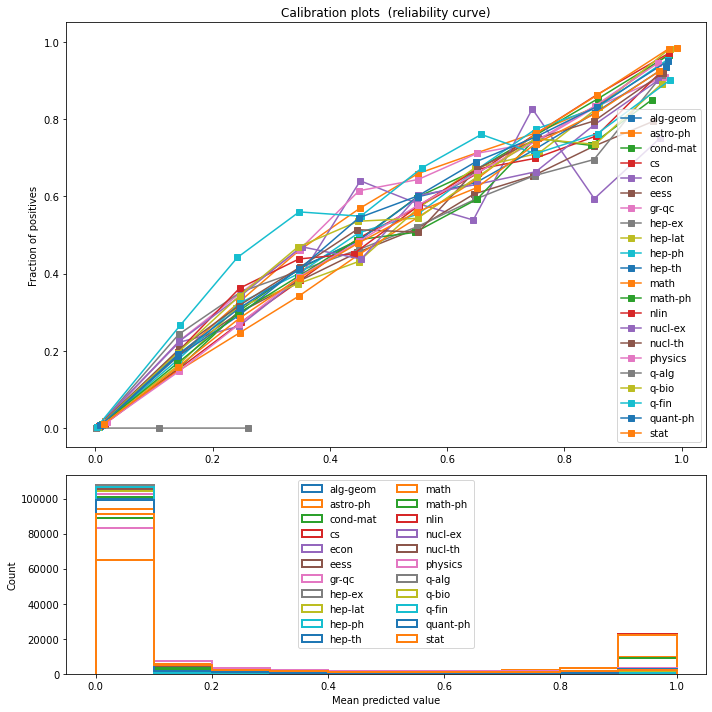

In [126]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
for i,category in enumerate(categories):
    
    prob_pos = linearSVC_models[category].predict_proba(X_test)[:,1]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true_SVC[:,i], prob_pos, n_bins=10)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % (category, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, histtype="step", lw=2, label=category)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

## Model 2 : Multinomial Naive Bayes

## Training for each category

In [78]:
%%time
# define the pipeline
multiNB_classifier = CalibratedClassifierCV(MultinomialNB()) 

# for each category train the model and get accuracy, auc
multiNB_models = {}
multiNB_features = {}
multiNB_preds = {}
# categories = ['math','cs','stat','physics']
for category in categories:
    # give pipelines unique names. important!  
    MultiNB_pipeline = Pipeline([
                (f'tfidf_{category}', TfidfVectorizer(stop_words=stop_words)),
                (f'clf_{category}', OneVsRestClassifier(multiNB_classifier, n_jobs=1)),
            ])
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    MultiNB_pipeline.fit(X_train, train[category])
    multiNB_models[category] = MultiNB_pipeline
    # compute the testing accuracy
    multiNB_prediction = MultiNB_pipeline.predict(X_test)
    multiNB_preds[category] = multiNB_prediction
    multiNB_accuracy = accuracy_score(test[category], multiNB_prediction)
    # compute auc
    multiNB_probas_ = MultiNB_pipeline.predict_proba(X_test)
    multiNB_fpr, multiNB_tpr, multiNB_thresholds = roc_curve(test[category], multiNB_probas_[:, 1])
    multiNB_roc_auc = auc(multiNB_fpr, multiNB_tpr)
    print("Accuracy : {} . Area under the ROC curve : {}".format(round(multiNB_accuracy,4), round(multiNB_roc_auc,4)))
    print()
    # get most predictive features
    multiNB_features[category] = feature_importance(SVC_pipeline)
    print(multiNB_features[category])

... Processing alg-geom


/Users/admin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/admin/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


Accuracy : 1.0 . Area under the ROC curve : nan

[{'token': 'statisticians', 'coef': 3.9216615829452444}, {'token': 'overparameterized', 'coef': 2.7538739956427176}, {'token': 'changepoint', 'coef': 2.562493924672226}, {'token': 'covariates', 'coef': 2.3968660218345943}, {'token': 'nonparametric', 'coef': 2.285182601577896}, {'token': 'minimax', 'coef': 2.2704341331554514}, {'token': 'blockmodel', 'coef': 2.133716668670229}, {'token': 'statistical', 'coef': 2.1116866298957158}, {'token': 'penalized', 'coef': 2.1040675652805847}, {'token': 'geostatistical', 'coef': 1.9330660894738414}]
... Processing astro-ph
Accuracy : 0.9743 . Area under the ROC curve : 0.9887

[{'token': 'statisticians', 'coef': 3.9216615829452444}, {'token': 'overparameterized', 'coef': 2.7538739956427176}, {'token': 'changepoint', 'coef': 2.562493924672226}, {'token': 'covariates', 'coef': 2.3968660218345943}, {'token': 'nonparametric', 'coef': 2.285182601577896}, {'token': 'minimax', 'coef': 2.2704341331554514}, {

Accuracy : 0.9904 . Area under the ROC curve : 0.9304

[{'token': 'statisticians', 'coef': 3.9216615829452444}, {'token': 'overparameterized', 'coef': 2.7538739956427176}, {'token': 'changepoint', 'coef': 2.562493924672226}, {'token': 'covariates', 'coef': 2.3968660218345943}, {'token': 'nonparametric', 'coef': 2.285182601577896}, {'token': 'minimax', 'coef': 2.2704341331554514}, {'token': 'blockmodel', 'coef': 2.133716668670229}, {'token': 'statistical', 'coef': 2.1116866298957158}, {'token': 'penalized', 'coef': 2.1040675652805847}, {'token': 'geostatistical', 'coef': 1.9330660894738414}]
... Processing nucl-th
Accuracy : 0.983 . Area under the ROC curve : 0.9411

[{'token': 'statisticians', 'coef': 3.9216615829452444}, {'token': 'overparameterized', 'coef': 2.7538739956427176}, {'token': 'changepoint', 'coef': 2.562493924672226}, {'token': 'covariates', 'coef': 2.3968660218345943}, {'token': 'nonparametric', 'coef': 2.285182601577896}, {'token': 'minimax', 'coef': 2.2704341331554514

### Top 10 features (words) for each category that help to predict category for given abstract

In [79]:
multiNB_features_df = pd.DataFrame(multiNB_features)
multiNB_features_df.apply(lambda x: [d['token'] for d in x], axis=0)

,alg-geom,astro-ph,cond-mat,cs,econ,eess,gr-qc,hep-ex,hep-lat,hep-ph,...,math-ph,nlin,nucl-ex,nucl-th,physics,q-alg,q-bio,q-fin,quant-ph,stat
0,statisticians,statisticians,statisticians,statisticians,statisticians,statisticians,statisticians,statisticians,statisticians,statisticians,...,statisticians,statisticians,statisticians,statisticians,statisticians,statisticians,statisticians,statisticians,statisticians,statisticians
1,overparameterized,overparameterized,overparameterized,overparameterized,overparameterized,overparameterized,overparameterized,overparameterized,overparameterized,overparameterized,...,overparameterized,overparameterized,overparameterized,overparameterized,overparameterized,overparameterized,overparameterized,overparameterized,overparameterized,overparameterized
2,changepoint,changepoint,changepoint,changepoint,changepoint,changepoint,changepoint,changepoint,changepoint,changepoint,...,changepoint,changepoint,changepoint,changepoint,changepoint,changepoint,changepoint,changepoint,changepoint,changepoint
3,covariates,covariates,covariates,covariates,covariates,covariates,covariates,covariates,covariates,covariates,...,covariates,covariates,covariates,covariates,covariates,covariates,covariates,covariates,covariates,covariates
4,nonparametric,nonparametric,nonparametric,nonparametric,nonparametric,nonparametric,nonparametric,nonparametric,nonparametric,nonparametric,...,nonparametric,nonparametric,nonparametric,nonparametric,nonparametric,nonparametric,nonparametric,nonparametric,nonparametric,nonparametric
5,minimax,minimax,minimax,minimax,minimax,minimax,minimax,minimax,minimax,minimax,...,minimax,minimax,minimax,minimax,minimax,minimax,minimax,minimax,minimax,minimax
6,blockmodel,blockmodel,blockmodel,blockmodel,blockmodel,blockmodel,blockmodel,blockmodel,blockmodel,blockmodel,...,blockmodel,blockmodel,blockmodel,blockmodel,blockmodel,blockmodel,blockmodel,blockmodel,blockmodel,blockmodel
7,statistical,statistical,statistical,statistical,statistical,statistical,statistical,statistical,statistical,statistical,...,statistical,statistical,statistical,statistical,statistical,statistical,statistical,statistical,statistical,statistical
8,penalized,penalized,penalized,penalized,penalized,penalized,penalized,penalized,penalized,penalized,...,penalized,penalized,penalized,penalized,penalized,penalized,penalized,penalized,penalized,penalized
9,geostatistical,geostatistical,geostatistical,geostatistical,geostatistical,geostatistical,geostatistical,geostatistical,geostatistical,geostatistical,...,geostatistical,geostatistical,geostatistical,geostatistical,geostatistical,geostatistical,geostatistical,geostatistical,geostatistical,geostatistical


### Predicting top 10 abstracts from test dataset and comparing it with the original value in non-segmented dataset

In [81]:
for i in range(0,20):
    print(test.title.iloc[i])
    predict_tags(test['abstract'].iloc[i], multiNB_models, labels = test.iloc[i,2:])
    print()

Three-dimensional flow in cavity with elevated helicity driven by
  parallel walls
Original Tags: ['physics']
Predicted Tags: []

On the eccentricity of Proxima b
Original Tags: ['astro-ph']
Predicted Tags: ['astro-ph']

A wrinkle in time: A case study in DNS poisoning
Original Tags: ['cs']
Predicted Tags: ['cs']

Unsupervised Multilingual Word Embeddings
Original Tags: ['cs']
Predicted Tags: ['cs']

Periodic Magnetic Geodesics on Heisenberg Manifolds
Original Tags: ['math']
Predicted Tags: ['math']

A Novel Survey for Young Substellar Objects with the W-band Filter. I.
  Filter Design and New Discoveries in Ophiuchus and Perseus
Original Tags: ['astro-ph']
Predicted Tags: ['astro-ph']

Safe Driving Capacity of Autonomous Vehicles
Original Tags: ['cs', 'eess']
Predicted Tags: ['cs']

Unconstrained Biometric Recognition: Summary of Recent SOCIA Lab.
  Research
Original Tags: ['cs']
Predicted Tags: ['cs']

Generalized thermalization in quenched free Fermionic models
Original Tags: ['cond

### Getting all predictions and true labels in the same order

In [82]:
# get all predictions
y_pred_multiNB = np.array(predict_tags(test.abstract, multiNB_models)).T

# get true labels in the same order
y_true_multiNB = test[list(multiNB_models.keys())].to_numpy()

print(f"y_true_SVC: {y_true_multiNB}") 
print(f"y_pred_SVC: {y_pred_multiNB}") 

y_true_SVC: [[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]
y_pred_SVC: [[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


## Model 3 : Logistic Regression

## Training for each category

In [103]:
%%time
# define the pipeline
LR_classifier = CalibratedClassifierCV(LogisticRegression(max_iter=1000)) 

# for each category train the model and get accuracy, auc
LR_models = {}
LR_features = {}
LR_preds = {}
# categories = ['math','cs','stat','physics']
for category in categories:
    # give pipelines unique names. important!  
    LR_pipeline = Pipeline([
                (f'tfidf_{category}', TfidfVectorizer(stop_words=stop_words)),
                (f'clf_{category}', OneVsRestClassifier(LR_classifier, n_jobs=1)),
            ])
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LR_pipeline.fit(X_train, train[category])
    LR_models[category] = LR_pipeline
    # compute the testing accuracy
    LR_prediction = LR_pipeline.predict(X_test)
    LR_preds[category] = LR_prediction
    LR_accuracy = accuracy_score(test[category], LR_prediction)
    # compute auc
    LR_probas_ = LR_pipeline.predict_proba(X_test)
    LR_fpr, LR_tpr, LR_thresholds = roc_curve(test[category], LR_probas_[:, 1])
    LR_roc_auc = auc(LR_fpr, LR_tpr)
    print("Accuracy : {} . Area under the ROC curve : {}".format(round(LR_accuracy,4), round(LR_roc_auc,4)))
    print()
    # get most predictive features
    LR_features[category] = feature_importance(LR_pipeline)
    print(LR_features[category])

... Processing alg-geom


/Users/admin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/admin/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


Accuracy : 1.0 . Area under the ROC curve : nan

[{'token': 'k_x', 'coef': 0.5067546296218624}, {'token': 'b_j', 'coef': 0.36035967344954994}, {'token': 'threefolds', 'coef': 0.31806467846993147}, {'token': 'fano', 'coef': 0.277944431877741}, {'token': 'canonical', 'coef': 0.23566703443777434}, {'token': 'varieties', 'coef': 0.2346257156706019}, {'token': 'classify', 'coef': 0.21388021049275546}, {'token': 'hyperplane', 'coef': 0.19778169460532977}, {'token': 'picard', 'coef': 0.19719171411697872}, {'token': 'curve', 'coef': 0.19575983682954418}]
... Processing astro-ph
Accuracy : 0.9828 . Area under the ROC curve : 0.9957

[{'token': 'telescope', 'coef': 12.035426189254808}, {'token': 'stellar', 'coef': 9.438051512296346}, {'token': 'astronomy', 'coef': 9.30589258748311}, {'token': 'galaxy', 'coef': 9.195720380121273}, {'token': 'stars', 'coef': 9.151339315261403}, {'token': 'galaxies', 'coef': 8.739056320066911}, {'token': 'astronomical', 'coef': 8.661113722738833}, {'token': 'astrop

Accuracy : 0.9895 . Area under the ROC curve : 0.9888

[{'token': 'nuclei', 'coef': 9.132527014459546}, {'token': 'nuclear', 'coef': 8.533691412059772}, {'token': 'neutron', 'coef': 6.338416277781013}, {'token': 'nucleon', 'coef': 5.689795361886503}, {'token': 'hydrodynamics', 'coef': 5.365953579658682}, {'token': 'skyrme', 'coef': 5.1248881625040195}, {'token': 'body', 'coef': 4.950724235034048}, {'token': 'hydrodynamic', 'coef': 4.728208266559639}, {'token': 'fission', 'coef': 4.681992472876426}, {'token': 'isotopes', 'coef': 4.503204999951907}]
... Processing physics
Accuracy : 0.9303 . Area under the ROC curve : 0.9473

[{'token': 'plasmas', 'coef': 6.53540401235035}, {'token': 'reynolds', 'coef': 6.470180934696191}, {'token': 'photonic', 'coef': 6.041820926403089}, {'token': 'physics', 'coef': 5.807133579965271}, {'token': 'plasma', 'coef': 5.166581045881452}, {'token': 'metasurface', 'coef': 5.164670030765423}, {'token': 'scintillator', 'coef': 4.989034865365648}, {'token': 'meta

### Top 10 features (words) for each category that help to predict category for given abstract

In [104]:
LR_features_df = pd.DataFrame(LR_features)
LR_features_df.apply(lambda x: [d['token'] for d in x], axis=0)

,alg-geom,astro-ph,cond-mat,cs,econ,eess,gr-qc,hep-ex,hep-lat,hep-ph,...,math-ph,nlin,nucl-ex,nucl-th,physics,q-alg,q-bio,q-fin,quant-ph,stat
0,k_x,telescope,materials,robot,economic,speech,gravitational,physics,lattice,lhc,...,rigorous,chaotic,nuclear,nuclei,plasmas,mathfrak,protein,financial,quantum,statistical
1,b_j,stellar,granular,art,choice,speaker,gravity,experiment,qcd,qcd,...,mathematical,integrable,reaction,nuclear,reynolds,tau,biological,economic,qubits,nonparametric
2,threefolds,astronomy,hall,languages,panel,audio,relativity,detector,sign,parton,...,superintegrable,chaos,neutron,neutron,photonic,u_q,biology,portfolio,qubit,bayesian
3,fano,galaxy,superconductors,language,economics,sound,spacetimes,hep,volume,gluon,...,rigorously,lax,measured,nucleon,physics,frak,phylogenetic,market,bell,minimax
4,canonical,stars,graphene,robots,empirical,music,spacetime,atlas,gauge,neutrino,...,lieb,cellular,reactions,hydrodynamics,plasma,group,genome,finance,qkd,covariates
5,varieties,galaxies,ising,codes,econometric,asr,kerr,collected,simulations,higgs,...,calogero,painlev,collisions,skyrme,metasurface,quantum,species,volatility,casimir,regression
6,classify,astronomical,condensed,automata,preferences,signal,cosmology,measured,staggered,axion,...,supermanifolds,nonlinear,experiment,body,scintillator,hat,neuroscience,trading,entanglement,package
7,hyperplane,astrophysical,superconducting,learning,macroeconomic,imaging,cosmological,lhcb,continuum,physics,...,bethe,soliton,nuclei,hydrodynamic,metasurfaces,let,brain,price,contextuality,likelihood
8,picard,radio,dot,semantic,policy,musical,schwarzschild,measurements,fermions,electroweak,...,sle,oscillators,experimental,fission,beam,dual,proteins,stock,entangled,estimators
9,curve,interstellar,colloidal,semantics,endogenous,signals,spherically,muon,theory,phenomenological,...,painlev,solitons,ucn,isotopes,geophysical,poisson,rna,economy,measurement,sample


### Predicting top 10 abstracts from test dataset and comparing it with the original value in non-segmented dataset

In [105]:
for i in range(0,20):
    print(test.title.iloc[i])
    predict_tags(test['abstract'].iloc[i], LR_models, labels = test.iloc[i,2:])
    print()

Three-dimensional flow in cavity with elevated helicity driven by
  parallel walls
Original Tags: ['physics']
Predicted Tags: ['physics']

On the eccentricity of Proxima b
Original Tags: ['astro-ph']
Predicted Tags: ['astro-ph']

A wrinkle in time: A case study in DNS poisoning
Original Tags: ['cs']
Predicted Tags: ['cs']

Unsupervised Multilingual Word Embeddings
Original Tags: ['cs']
Predicted Tags: ['cs']

Periodic Magnetic Geodesics on Heisenberg Manifolds
Original Tags: ['math']
Predicted Tags: ['math']

A Novel Survey for Young Substellar Objects with the W-band Filter. I.
  Filter Design and New Discoveries in Ophiuchus and Perseus
Original Tags: ['astro-ph']
Predicted Tags: ['astro-ph']

Safe Driving Capacity of Autonomous Vehicles
Original Tags: ['cs', 'eess']
Predicted Tags: ['cs']

Unconstrained Biometric Recognition: Summary of Recent SOCIA Lab.
  Research
Original Tags: ['cs']
Predicted Tags: ['cs']

Generalized thermalization in quenched free Fermionic models
Original Tag

### Getting all predictions and true labels in the same order

In [106]:
# get all predictions
y_pred_LR = np.array(predict_tags(test.abstract, LR_models)).T

# get true labels in the same order
y_true_LR = test[list(LR_models.keys())].to_numpy()

print(f"y_true_SVC: {y_true_LR}") 
print(f"y_pred_SVC: {y_pred_LR}")

y_true_SVC: [[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]
y_pred_SVC: [[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


## Model 4 : Random Forest

In [110]:
%%time
# define the pipeline
# classifier = CalibratedClassifierCV(RandomForestClassifier()) 

# for each category train the model and get accuracy, auc
RF_models = {}
RF_features = {}
RF_preds = {}
# categories = ['math','cs','stat','physics']
for category in categories:

    RF_pipeline = Pipeline([
                (f'tfidf_{category}', TfidfVectorizer(stop_words=stop_words)),
                (f'clf_{category}', RandomForestClassifier(n_estimators=10)),
            ])
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    RF_pipeline.fit(X_train, train[category])
    RF_models[category] = RF_pipeline
    # compute the testing accuracy
    RF_prediction = RF_pipeline.predict(X_test)
    RF_preds[category] = RF_prediction
    RF_accuracy = accuracy_score(test[category], RF_prediction)
    # compute auc
    RF_probas_ = RF_pipeline.predict_proba(X_test)
    RF_fpr, RF_tpr, RF_thresholds = roc_curve(test[category], RF_probas_[:, 1])
    RF_roc_auc = auc(RF_fpr, RF_tpr)
    print("Accuracy : {} . Area under the ROC curve : {}".format(round(RF_accuracy,4), round(RF_roc_auc,4)))
    print()

... Processing alg-geom


/Users/admin/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


Accuracy : 1.0 . Area under the ROC curve : nan

... Processing astro-ph
Accuracy : 0.9678 . Area under the ROC curve : 0.9859

... Processing cond-mat
Accuracy : 0.932 . Area under the ROC curve : 0.957

... Processing cs
Accuracy : 0.9008 . Area under the ROC curve : 0.9584

... Processing econ
Accuracy : 0.9959 . Area under the ROC curve : 0.7771

... Processing eess
Accuracy : 0.9626 . Area under the ROC curve : 0.8272

... Processing gr-qc
Accuracy : 0.9716 . Area under the ROC curve : 0.9587

... Processing hep-ex
Accuracy : 0.9848 . Area under the ROC curve : 0.9406

... Processing hep-lat
Accuracy : 0.9936 . Area under the ROC curve : 0.8871

... Processing hep-ph
Accuracy : 0.9712 . Area under the ROC curve : 0.9633

... Processing hep-th
Accuracy : 0.9642 . Area under the ROC curve : 0.9376

... Processing math
Accuracy : 0.8975 . Area under the ROC curve : 0.9487

... Processing math-ph
Accuracy : 0.9706 . Area under the ROC curve : 0.7851

... Processing nlin
Accuracy : 0.9

In [162]:
for category in categories:
    
    features = RF_models[category][0].get_feature_names()
    coef = RF_features[category].tolist()[0]
    RF_features[category] = pd.DataFrame(list(zip(features,coef)), columns = ['token','coef'])\
                                .nlargest(10,'coef').to_dict(orient = 'records')


### Top 10 features (words) for each category that help to predict category for given abstract

In [163]:
RF_features_df = pd.DataFrame(RF_features)
RF_features_df.apply(lambda x: [d['token'] for d in x], axis=0)

,alg-geom,astro-ph,cond-mat,cs,econ,eess,gr-qc,hep-ex,hep-lat,hep-ph,...,math-ph,nlin,nucl-ex,nucl-th,physics,q-alg,q-bio,q-fin,quant-ph,stat
0,divisor,stellar,materials,performance,economic,speech,black,production,qcd,quark,...,theory,chaotic,collisions,nucleon,laser,formal,protein,asset,quantum,regression
1,classify,galaxies,quantum,algorithms,macroeconomic,performance,relativity,detector,lattice,lhc,...,quantum,integrable,pb,quark,beam,sl,cells,market,qubit,machine
2,du,dark,states,networks,panel,wireless,gravitational,lhcb,n_f,meson,...,operators,breather,nuclei,nuclei,fluid,frak,biochemical,financial,qubits,neural
3,map,formation,superconductivity,data,firms,proposed,spacetimes,lepton,gauge,qcd,...,equation,soliton,nuclear,collisions,reynolds,dual,brain,markets,entanglement,learning
4,subset,telescope,paper,training,econometric,image,scalar,cms,pion,tev,...,equations,rogue,neutron,nucleus,light,simply,individuals,volatility,states,estimator
5,olsson,ray,magnetic,visual,income,based,gravity,collisions,quark,masses,...,schr,nonlinear,proton,proton,electron,specializations,organisms,price,state,inference
6,curve,stars,lattice,learning,treatment,paper,einstein,collider,spacings,heavy,...,dimensional,dynamics,gev,nuclear,water,morphisms,population,stock,entangled,training
7,let,cosmological,insulator,language,paper,audio,universe,lhc,su,standard,...,algebra,solitons,nn,qcd,optical,double,proteins,pricing,photon,models
8,four,star,films,image,market,signals,hawking,hadron,wilson,production,...,show,bifurcation,nucleon,neutron,atoms,new,gene,economic,bell,algorithm
9,excluding,observations,band,based,wage,voice,hole,quark,clover,quarks,...,operator,system,alice,hadron,paper,prove,infection,risk,mechanics,data


### Predicting top 10 abstracts from test dataset and comparing it with the original value in non-segmented dataset

In [165]:
for i in range(0,20):
    print(test.title.iloc[i])
    predict_tags(test['abstract'].iloc[i], RF_models, labels = test.iloc[i,2:])
    print()

Three-dimensional flow in cavity with elevated helicity driven by
  parallel walls
Original Tags: ['physics']
Predicted Tags: []

On the eccentricity of Proxima b
Original Tags: ['astro-ph']
Predicted Tags: []

A wrinkle in time: A case study in DNS poisoning
Original Tags: ['cs']
Predicted Tags: ['cs']

Unsupervised Multilingual Word Embeddings
Original Tags: ['cs']
Predicted Tags: ['cs']

Periodic Magnetic Geodesics on Heisenberg Manifolds
Original Tags: ['math']
Predicted Tags: []

A Novel Survey for Young Substellar Objects with the W-band Filter. I.
  Filter Design and New Discoveries in Ophiuchus and Perseus
Original Tags: ['astro-ph']
Predicted Tags: ['astro-ph']

Safe Driving Capacity of Autonomous Vehicles
Original Tags: ['cs', 'eess']
Predicted Tags: ['cs']

Unconstrained Biometric Recognition: Summary of Recent SOCIA Lab.
  Research
Original Tags: ['cs']
Predicted Tags: ['cs']

Generalized thermalization in quenched free Fermionic models
Original Tags: ['cond-mat', 'hep-th',

### Getting all predictions and true labels in the same order

In [166]:
# get all predictions
y_pred_RF = np.array(predict_tags(test.abstract, RF_models)).T

# get true labels in the same order
y_true_RF = test[list(RF_models.keys())].to_numpy()
y_true_RF
y_pred_RF

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Models Comparison

### Calculating Hamming Loss (Lower is Better) and Accuracy Score for all models across all labels/categories

In [168]:
print(f"Linear SVC Hamming Loss: {hamming_loss(y_true_SVC,y_pred_SVC)}")
print(f"Linear SVC Accuracy Score: {accuracy_score(y_true_SVC,y_pred_SVC)}")

print(f"Multinomial Naive Bayes Hamming Loss: {hamming_loss(y_true_multiNB,y_pred_multiNB)}")
print(f"Multinomial Naive Bayes Accuracy Score: {accuracy_score(y_true_multiNB,y_pred_multiNB)}")

print(f"Logistic Regression Hamming Loss: {hamming_loss(y_true_LR,y_pred_LR)}")
print(f"Logistic Regression Accuracy Score: {accuracy_score(y_true_LR,y_pred_LR)}")

print(f"Random Forest Hamming Loss: {hamming_loss(y_true_RF,y_pred_RF)}")
print(f"Random Forest Accuracy Score: {accuracy_score(y_true_RF,y_pred_RF)}")

Linear SVC Hamming Loss: 0.02227766121182933
Linear SVC Accuracy Score: 0.6515392879635461
Multinomial Naive Bayes Hamming Loss: 0.03222215860677684
Multinomial Naive Bayes Accuracy Score: 0.5366483903234172
Logistic Regression Hamming Loss: 0.023216877776393207
Logistic Regression Accuracy Score: 0.6384803467565665
Random Forest Hamming Loss: 0.03510674484630696
Random Forest Accuracy Score: 0.48670951728225836


### We also calculate Hamming Score which can be used as a metric in place of Accuracy Score for multi label classification

In [89]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [169]:
print(f"Linear SVC Hamming Score: {hamming_score(y_true_SVC,y_pred_SVC)}")

print(f"Multinomial Naive Bayes Hamming Score: {hamming_score(y_true_multiNB,y_pred_multiNB)}")

print(f"Logistic Regression Hamming Score: {hamming_score(y_true_LR,y_pred_LR)}")

print(f"Random Forest Hamming Score: {hamming_score(y_true_RF,y_pred_RF)}")

Linear SVC Hamming Score: 0.7830497280600085
Multinomial Naive Bayes Hamming Score: 0.6375193307476678
Logistic Regression Hamming Score: 0.7737422885651128
Random Forest Hamming Score: 0.5764996171847022


### Plotting abstract distribution by true category vs predicted

In [172]:
source = pd.DataFrame(y_pred_SVC, columns = list(linearSVC_models.keys())).apply(sum).reset_index().rename(columns = {0:'count'})
ptotalText = alt.Text('PercentOfTotal:Q', format = '.2%')

# set up bar chart
chart2 = alt.Chart(source).transform_joinaggregate(
    TotalPapers='sum(count)',
).transform_calculate(
    PercentOfTotal="datum.count / datum.TotalPapers"
).mark_bar().encode(
    x = 'index',
    y = 'count',
    tooltip = ['index','count', ptotalText]
).properties(
    title='arXiv Papers by Predicted Category by Linear SVC Model',
    width = 800
)

# add percentage labels
chart2 = chart2 + chart2.mark_text(
    align='center',
    baseline='middle',
    dx= 3,  # Nudges text to right so it doesn't appear on top of the bar,
    dy = -5
).encode(
    text = ptotalText
) 

# concatenate charts
alt.vconcat(chart, chart2)

alt.VConcatChart(...)

In [173]:
source = pd.DataFrame(y_pred_multiNB, columns = list(multiNB_models.keys())).apply(sum).reset_index().rename(columns = {0:'count'})
ptotalText = alt.Text('PercentOfTotal:Q', format = '.2%')

# set up bar chart
chart2 = alt.Chart(source).transform_joinaggregate(
    TotalPapers='sum(count)',
).transform_calculate(
    PercentOfTotal="datum.count / datum.TotalPapers"
).mark_bar().encode(
    x = 'index',
    y = 'count',
    tooltip = ['index','count', ptotalText]
).properties(
    title='arXiv Papers by Predicted Category by Multinomial Naive Bayes Model',
    width = 800
)

# add percentage labels
chart2 = chart2 + chart2.mark_text(
    align='center',
    baseline='middle',
    dx= 3,  # Nudges text to right so it doesn't appear on top of the bar,
    dy = -5
).encode(
    text = ptotalText
) 

# concatenate charts
alt.vconcat(chart, chart2)

alt.VConcatChart(...)

In [174]:
source = pd.DataFrame(y_pred_LR, columns = list(LR_models.keys())).apply(sum).reset_index().rename(columns = {0:'count'})
ptotalText = alt.Text('PercentOfTotal:Q', format = '.2%')

# set up bar chart
chart2 = alt.Chart(source).transform_joinaggregate(
    TotalPapers='sum(count)',
).transform_calculate(
    PercentOfTotal="datum.count / datum.TotalPapers"
).mark_bar().encode(
    x = 'index',
    y = 'count',
    tooltip = ['index','count', ptotalText]
).properties(
    title='arXiv Papers by Predicted Category by Logistic Regression Model',
    width = 800
)

# add percentage labels
chart2 = chart2 + chart2.mark_text(
    align='center',
    baseline='middle',
    dx= 3,  # Nudges text to right so it doesn't appear on top of the bar,
    dy = -5
).encode(
    text = ptotalText
) 

# concatenate charts
alt.vconcat(chart, chart2)

alt.VConcatChart(...)

In [175]:
source = pd.DataFrame(y_pred_RF, columns = list(RF_models.keys())).apply(sum).reset_index().rename(columns = {0:'count'})
ptotalText = alt.Text('PercentOfTotal:Q', format = '.2%')

# set up bar chart
chart2 = alt.Chart(source).transform_joinaggregate(
    TotalPapers='sum(count)',
).transform_calculate(
    PercentOfTotal="datum.count / datum.TotalPapers"
).mark_bar().encode(
    x = 'index',
    y = 'count',
    tooltip = ['index','count', ptotalText]
).properties(
    title='arXiv Papers by Predicted Category by Random Forest Classifier Model',
    width = 800
)

# add percentage labels
chart2 = chart2 + chart2.mark_text(
    align='center',
    baseline='middle',
    dx= 3,  # Nudges text to right so it doesn't appear on top of the bar,
    dy = -5
).encode(
    text = ptotalText
) 

# concatenate charts
alt.vconcat(chart, chart2)

alt.VConcatChart(...)